# ASL Videos Downloader

In [1]:
import os, sys, json

import pandas as pd
import numpy as np

sys.path.insert(0, '../src')
from config import *

import youtube_dl
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

In [2]:
map_sign_file_path = os.path.join(ROOT_PATH, RAW_DATA_DIR, MAP_JSON_FILE)
with open(map_sign_file_path) as f:
    label_dict = json.load(f)

In [3]:
asl_video_file_path = os.path.join(ROOT_PATH, RAW_DATA_DIR, 'MSASL/MSASL_train.json')
with open(asl_video_file_path) as f:
    video_info = json.load(f)
video_info[0]

{'org_text': 'match [light-a-MATCH]',
 'clean_text': 'match',
 'start_time': 0.0,
 'signer_id': 0,
 'signer': 0,
 'start': 0,
 'end': 83,
 'file': 'match light-a-MATCH',
 'label': 830,
 'height': 360.0,
 'fps': 30.0,
 'end_time': 2.767,
 'url': 'https://www.youtube.com/watch?v=C37R_Ix8-qs',
 'text': 'match',
 'box': [0.05754461884498596, 0.21637457609176636, 1.0, 0.7300844192504883],
 'width': 640.0}

In [6]:
def format_time(seconds):
    ms = int((seconds % 1) * 1000)
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}.{ms:03d}"

#ext_url_dict = {record['text']: record['url'] for record in video_info if record['clean_text'] in label_dict.keys()}
text_url_dict = {text: [(record['url'],record['start_time'],record['end_time'],record['signer_id'])  for record in video_info if record['clean_text'] == text] for text in label_dict.keys()}
text_url_dict

{'TV': [],
 'after': [('https://www.youtube.com/watch?v=oWJM0FfPSHI', 0.0, 2.022, 2),
  ('https://www.youtube.com/watch?v=mCjHYreiZ24', 185.886, 190.857, 32),
  ('https://www.youtube.com/watch?v=xaHll2DRUkg', 28.45, 29.722, 390),
  ('https://www.youtube.com/watch?v=xaHll2DRUkg', 31.094, 32.031, 390),
  ('https://www.youtube.com/watch?v=xaHll2DRUkg', 32.098, 33.404, 390),
  ('https://www.youtube.com/watch?v=amWUHjchp8s', 129.533, 134.267, 41),
  ('https://www.youtube.com/watch?v=_qRft6V2XC0', 118.919, 120.387, 203)],
 'airplane': [('https://www.youtube.com/watch?v=kLNecAikHa4', 23.36, 27.0, 94),
  ('https://www.youtube.com/watch?v=kf6kjPKf__w', 0.0, 4.42, 2),
  ('https://www.youtube.com/watch?v=aa7YpBt_SGk', 31.899, 33.567, 95),
  ('https://www.youtube.com/watch?v=aa7YpBt_SGk', 33.567, 34.935, 95),
  ('https://www.youtube.com/watch?v=ac1Lgm6qns8', 40.36, 44.96, 77),
  ('https://www.youtube.com/watch?v=ac1Lgm6qns8', 45.2, 49.52, 77),
  ('https://www.youtube.com/watch?v=uPWzbFvXcuw', 31.8

In [7]:
sorted_text_url_dict = {key: text_url_dict[key] for key in sorted(text_url_dict) if len(text_url_dict[key])>0 }
sorted_text_url_dict.keys()

dict_keys(['after', 'airplane', 'all', 'animal', 'any', 'apple', 'aunt', 'bad', 'bath', 'bed', 'bedroom', 'before', 'better', 'bird', 'black', 'blue', 'boat', 'book', 'boy', 'brother', 'brown', 'bug', 'bye', 'can', 'car', 'carrot', 'cat', 'cereal', 'child', 'chocolate', 'close', 'closet', 'cloud', 'cow', 'cry', 'cute', 'dance', 'dirty', 'dog', 'down', 'drawer', 'drink', 'drop', 'dry', 'dryer', 'duck', 'elephant', 'face', 'fast', 'find', 'fine', 'finish', 'first', 'fish', 'flag', 'flower', 'for', 'frog', 'giraffe', 'girl', 'give', 'go', 'grass', 'green', 'gum', 'hair', 'happy', 'hat', 'hate', 'have', 'head', 'hear', 'hello', 'home', 'horse', 'hot', 'hungry', 'if', 'jacket', 'jump', 'kiss', 'lamp', 'later', 'like', 'lion', 'listen', 'loud', 'mad', 'make', 'man', 'many', 'milk', 'moon', 'morning', 'mouse', 'mouth', 'night', 'no', 'nose', 'not', 'now', 'nuts', 'old', 'open', 'orange', 'outside', 'pencil', 'pig', 'pizza', 'please', 'police', 'pool', 'quiet', 'radio', 'rain', 'read', 'red', 

In [8]:
download_path = os.path.join(ROOT_PATH, RAW_DATA_DIR, 'MSASL', 'Videos')

def download_video(url,start_time_str,end_time_str,signer_id, word):
    text_dir = os.path.join(download_path, word)
    output_file = f'{text_dir}/{word}_{url[-8:]}_{signer_id}.mp4'
    os.makedirs(text_dir, exist_ok=True)  
    ydl_opts = {
        'outtmpl': output_file,
        'no-check-certificate': True,
        'postprocessors': [{
            'key': 'FFmpegVideoConvertor',
            'preferedformat': 'mp4'            
        }],
        'postprocessor_args': [
                '-ss', start_time_str,
                '-t', end_time_str,
            ],
            'format': 'best'
    }
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        try:            
            ydl.download([url])
            
            ffmpeg_extract_subclip(output_file, start_time_str, end_time_str, targetname="{}_trimmed.mp4".format(output_file[:-4]))
            os.remove(output_file)    
        except Exception as e:
            print(f"Error downloading {url}: {e}")            

In [9]:
os.makedirs(download_path, exist_ok=True)  # Create the subdirectory if it doesn't exist
for text, urls in text_url_dict.items():
    for (url,start,end,signer_id) in urls:
        download_video(url, start, end, signer_id, text)

[youtube] oWJM0FfPSHI: Downloading webpage
[youtube] oWJM0FfPSHI: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\after\after_M0FfPSHI_2.mp4
[download] 100% of 1.36MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\after\after_M0FfPSHI_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] mCjHYreiZ24: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\after\after_HYreiZ24_32.mp4
[download] 100% of 27.23MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\after\after_HYreiZ24_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] xaHll2DRUkg: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] xaHll2DRUkg: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] xaHll2DRUkg: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] amWUHjchp8s: Downloading webpage
[youtube] amWUHjchp8s: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\after\after_UHjchp8s_41.mp4
[download] 100% of 4.75MiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\after\after_UHjchp8s_41.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] _qRft6V2XC0: Downloading webpage
[youtube] _qRft6V2XC0: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\after\after_ft6V2XC0_203.mp4
[download] 100% of 21.85MiB in 00:01                   
[ffmpeg] Not converting video fil

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=uPWzbFvXcuw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] gDsgZW0VogE: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=gDsgZW0VogE: ERROR: Video unavailable
[youtube] 7THZHZ0whKc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\airplane\airplane_ZHZ0whKc_144.mp4
[download] 100% of 2.63MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\airplane\airplane_ZHZ0whKc_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] vcrTUbE1NoY: Downloading webpage
[youtube] vcrTUbE1NoY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\airplane\airplane_TUbE1NoY_286.mp4
[download] 100% of 18.92MiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\airplane\airplane_TUbE1NoY_286.mp4 - already is in target format mp4
Moviepy - 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=4QF9ZqvPGKE: ERROR: Video unavailable
[youtube] tJ2SbVaNdCo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_SbVaNdCo_32.mp4
[download] 100% of 23.28MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_SbVaNdCo_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] jwbgKkXE3KI: Downloading webpage
[youtube] jwbgKkXE3KI: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_gKkXE3KI_62.mp4
[download] 100% of 459.27KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_gKkXE3KI_62.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - C

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] iERRGfH_giQ: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=iERRGfH_giQ: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] tUJgkaaix2w: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=tUJgkaaix2w: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] s-yWU-7IUkY: Downloading webpage
[youtube] s-yWU-7IUkY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_WU-7IUkY_0.mp4
[download] 100% of 44.13KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_WU-7IUkY_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] V7WEPn3RJsc: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=V7WEPn3RJsc: ERROR: Video unavailable
[youtube] oDDEMBNkB9M: Downloading webpage
[youtube] oDDEMBNkB9M: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_EMBNkB9M_345.mp4
[download] 100% of 35.90MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_EMBNkB9M_345.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] IGUHlILG8AA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_HlILG8AA_0.mp4
[download] 100% of 30.95KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_HlILG8AA_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Com

Moviepy - Command successful
[youtube] k3c4uVHBFR4: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=k3c4uVHBFR4: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] 3RB642y8sgo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_642y8sgo_230.mp4
[download] 100% of 24.80MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_642y8sgo_230.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] R76TduqLr3E: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=R76TduqLr3E: ERROR: Video unavailable
[youtube] R76TduqLr3E: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=R76TduqLr3E: ERROR: Video unavailable
[youtube] q_p38s5JsXo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_38s5JsXo_12.mp4
[download] 100% of 30.82MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_38s5JsXo_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] q_p38s5JsXo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_38s5JsXo_12.mp4
[download] 100% of 30.82MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\all\all_38s5JsXo_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] qw9KjK2s_DM: Download

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=FeGQrm6_hWs: ERROR: Video unavailable
[youtube] FBD4NFz4QaA: Downloading webpage
[youtube] FBD4NFz4QaA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\animal\animal_4NFz4QaA_126.mp4
[download] 100% of 51.28MiB in 00:04                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\animal\animal_4NFz4QaA_126.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] jcnSKdZFr-M: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\animal\animal_SKdZFr-M_124.mp4
[download] 100% of 21.09MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\animal\animal_SKdZFr-M_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Dbq2emMTZE0: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\any\any_2emMTZE0_0.mp4
[download] 100% of 114.17KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\any\any_2emMTZE0_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] BBdzDiRSooo: Downloading webpage
[youtube] BBdzDiRSooo: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\any\any_zDiRSooo_0.mp4
[download] 100% of 444.09KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\any\any_zDiRSooo_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[yout

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] wEllyA0JhDI: Downloading webpage
[youtube] wEllyA0JhDI: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\any\any_lyA0JhDI_0.mp4
[download] 100% of 339.38KiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\any\any_lyA0JhDI_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] AJ-fNfr0T1c: Downloading webpage
[youtube] AJ-fNfr0T1c: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\any\any_fNfr0T1c_0.mp4
[download] 100% of 145.10KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\any\any_fNfr0T1c_0.mp4 - already is in target format mp4
Moviepy - Running:

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] ax2UGtA8h3E: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_UGtA8h3E_97.mp4
[download] 100% of 8.49MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_UGtA8h3E_97.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 4t7_FlKNhx8: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=4t7_FlKNhx8: ERROR: Video unavailable
[youtube] 8EAyQcYHd3g: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_yQcYHd3g_124.mp4
[download] 100% of 13.38MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_yQcYHd3g_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] h893wq_Jcw0: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_3wq_Jcw0_24.mp4
[download] 100% of 24.82MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_3wq_Jcw0_24.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] bJ2lPH4pfgE:

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=QxOYnMWCVhM&t=4s: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] kUKnnOCTBfU: Downloading webpage
[youtube] kUKnnOCTBfU: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_nnOCTBfU_0.mp4
[download] 100% of 178.57KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_nnOCTBfU_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] pc0-gVEETVg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_-gVEETVg_72.mp4
[download] 100% of 9.38MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_-gVEETVg_72.mp4 - already is in tar

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=x_WUiBjYBhg: ERROR: Video unavailable
[youtube] x_WUiBjYBhg: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=x_WUiBjYBhg: ERROR: Video unavailable
[youtube] g0-WX7prrxo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=g0-WX7prrxo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] oDnz2t98VYk: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=oDnz2t98VYk: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] KRrKqGEGdMg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_KqGEGdMg_32.mp4
[download] 100% of 44.12MiB in 00:03                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_KqGEGdMg_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] D9wjtk3SKFM: Downloading webpage
[youtube] D9wjtk3SKFM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_jtk3SKFM_203.mp4
[download] 100% of 43.77MiB in 00:13                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\apple\apple_jtk3SKFM_203.mp4 - already is in targ

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=4rcQkD28sMw: ERROR: Video unavailable
[youtube] 12Cqpj9g96Q: Downloading webpage
[youtube] 12Cqpj9g96Q: Downloading player 50cf60f0
[youtube] 12Cqpj9g96Q: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_qpj9g96Q_107.mp4
[download] 100% of 8.32MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_qpj9g96Q_107.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] YoIiaXt5llc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_iaXt5llc_0.mp4
[download] 100% of 57.55KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_iaXt5llc_0.mp4 - already is in target forma

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=4M6Y4QgvO2k: ERROR: Video unavailable
[youtube] 1RjPFNyJ4Tw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] XUg1eKl65p4: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_1eKl65p4_124.mp4
[download] 100% of 10.32MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_1eKl65p4_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] pv1yeA4iHmU: Downloading webpage
[youtube] pv1yeA4iHmU: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_yeA4iHmU_319.mp4
[download] 100% of 45.45MiB in 00:06                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_yeA4iHmU_319.mp4 - already is in target form

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] _nRG5Rx0_tA: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading www.youtube.com/watch?v=_nRG5Rx0_tA: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] GPK4S8wzLec: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=GPK4S8wzLec: ERROR: Video unavailable
[youtube] GPK4S8wzLec: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=GPK4S8wzLec: ERROR: Video unavailable
[youtube] KHJjHjG-8JU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_U&t=109s_384.mp4
[download] 100% of 36.69MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_U&t=109s_384.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] KHJjHjG-8JU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_U&t=109s_384.mp4
[download] 100% of 36.69MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\aunt\aunt_U&t=109s_384.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] QZ26yX7Mfm

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=KeSmFj1ahU0: ERROR: Video unavailable
[youtube] KeSmFj1ahU0: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=KeSmFj1ahU0: ERROR: Video unavailable
[youtube] z8e_-viWx9E: Downloading webpage
[youtube] z8e_-viWx9E: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad__-viWx9E_40.mp4
[download] 100% of 67.57MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad__-viWx9E_40.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 2FeZ-DEp9sE: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=2FeZ-DEp9sE: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] BUhCGlNOqRA: Downloading webpage
[youtube] BUhCGlNOqRA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_CGlNOqRA_0.mp4
[download] 100% of 144.22KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_CGlNOqRA_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] iMUjcZCLaGo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] WprUBqi3iBc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_UBqi3iBc_72.mp4
[download] 100% of 12.02MiB in 00:03                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_UBqi3iBc_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] rnr_aY0X0dQ: Downloading webpage
[youtube] rnr_aY0X0dQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad__aY0X0dQ_312.mp4
[download] 100% of 115.78MiB in 00:11                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad__aY0X0dQ_312.mp4 - already is in target form

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 9ko47J797_U: Downloading webpage
[youtube] 9ko47J797_U: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_7_U&t=8s_98.mp4
[download] 100% of 45.36MiB in 00:12                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_7_U&t=8s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] cF6XScPZDsE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_XScPZDsE_32.mp4
[download] 100% of 32.14MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_XScPZDsE_32.mp4 - already is in target format mp4
Movi

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=_yqDuSdl28Q: ERROR: Video unavailable
[youtube] _ZlZH4b0C44: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_ZH4b0C44_388.mp4
[download] 100% of 21.99MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_ZH4b0C44_388.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] R_ES8RZua1g: Downloading webpage
[youtube] R_ES8RZua1g: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_S8RZua1g_40.mp4
[download] 100% of 25.89MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_S8RZua1g_40.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=0e8jwNFLfhw: ERROR: Video unavailable
[youtube] vkjQHTjhcD4: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=vkjQHTjhcD4: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] JRUhj2-u3GQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_hj2-u3GQ_0.mp4
[download] 100% of 189.95KiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bad\bad_hj2-u3GQ_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] moInskLVdMc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_nskLVdMc_14.mp4
[download] 100% of 452.68KiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_nskLVdMc_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".joi

[youtube] THnAOsOMHWY: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=THnAOsOMHWY: ERROR: Video unavailable
[youtube] k0T-yY_HrEQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_-yY_HrEQ_88.mp4
[download] 100% of 4.36MiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_-yY_HrEQ_88.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] k0T-yY_HrEQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_-yY_HrEQ_88.mp4
[download] 100% of 4.36MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_-yY_HrEQ_88.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] k0T-yY_HrEQ: Dow

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 7bbaTCiY58w: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_aTCiY58w_316.mp4
[download] 100% of 194.18KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_aTCiY58w_316.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] FrXzepGn4RI: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_zepGn4RI_124.mp4
[download] 100% of 21.89MiB in 00:09                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bath\bath_zepGn4RI_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] a80af5anctI: Downloading we

[youtube] 5RRFd7svaMs: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=5RRFd7svaMs: ERROR: Video unavailable
[youtube] xPb8AD1rON0: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bed\bed_8AD1rON0_124.mp4
[download] 100% of 40.91MiB in 00:04                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bed\bed_8AD1rON0_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 12eeoE4uG_k: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bed\bed_eoE4uG_k_0.mp4
[download] 100% of 214.43KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bed\bed_eoE4uG_k_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] BD1aiEB8sK8: Download

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=tUJgkaaix2w: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] A0TTA7Rlkzc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bed\bed_TA7Rlkzc_24.mp4
[download] 100% of 28.45MiB in 00:06                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bed\bed_TA7Rlkzc_24.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] A0TTA7Rlkzc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bed\bed_TA7Rlkzc_24.mp4
[download] 100% of 28.45MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bed\bed_TA7Rlkzc_24.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Com

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=tUJgkaaix2w: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] AiozVha_k4o: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bedroom\bedroom_zVha_k4o_12.mp4
[download] 100% of 66.85MiB in 00:10                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bedroom\bedroom_zVha_k4o_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] AiozVha_k4o: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bedroom\bedroom_zVha_k4o_12.mp4
[download] 100% of 66.85MiB in 00:06                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bedroom\bedroom_zVha_k4o_12.mp4 - already is in target format mp4
Moviepy - Running:
>

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=IX5H-ecgp_0: ERROR: Video unavailable
[youtube] IX5H-ecgp_0: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=IX5H-ecgp_0: ERROR: Video unavailable
[youtube] 14sywd-VUsE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bedroom\bedroom_ywd-VUsE_24.mp4
[download] 100% of 24.43MiB in 00:06                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bedroom\bedroom_ywd-VUsE_24.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 14sywd-VUsE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bedroom\bedroom_ywd-VUsE_24.mp4
[download] 100% of 24.43MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bedroom\bedroom_ywd-VUsE_24.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] ikmUKffwp-I: Downloading webpage
[youtube] ikmUKffwp-I: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\better\better_UKffwp-I_0.mp4
[download] 100% of 132.75KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\better\better_UKffwp-I_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 5S3qaGLdPmE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\better\better_qaGLdPmE_32.mp4
[download] 100% of 34.76MiB in 00:03                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\better\better_qaGLdPmE_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
M

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] BC2ahgTLYbk: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=BC2ahgTLYbk: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] ohjlMkxe1Wc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_lMkxe1Wc_88.mp4
[download] 100% of 7.00MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_lMkxe1Wc_88.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] ohjlMkxe1Wc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_lMkxe1Wc_88.mp4
[download] 100% of 7.00MiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_lMkxe1Wc_88.mp4 - already is in target format mp4
Moviepy - Run

[youtube] ztgpzeGwBcw: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=ztgpzeGwBcw: ERROR: Video unavailable
[youtube] KRrKqGEGdMg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_KqGEGdMg_32.mp4
[download] 100% of 44.12MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_KqGEGdMg_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 6PrrP_W_960: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_rP_W_960_13.mp4
[download] 100% of 318.86KiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_rP_W_960_13.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)


Moviepy - Command successful
[youtube] o9GSFqvikro: Downloading webpage
[youtube] o9GSFqvikro: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_SFqvikro_316.mp4
[download] 100% of 255.33KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_SFqvikro_316.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] tlOv7Un1zPw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_v7Un1zPw_107.mp4
[download] 100% of 6.54MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bird\bird_v7Un1zPw_107.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] K8c-np9zNT8: Download

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] QTbj2GM5ohs: Downloading webpage
[youtube] QTbj2GM5ohs: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_j2GM5ohs_94.mp4
[download] 100% of 23.31MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_j2GM5ohs_94.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] TLoZKdMeA8w: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=TLoZKdMeA8w: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] mfrGIHTnKvI: Downloading webpage
[youtube] mfrGIHTnKvI: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_GIHTnKvI_94.mp4
[download] 100% of 31.44MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_GIHTnKvI_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] mCjHYreiZ24: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_HYreiZ24_32.mp4
[download] 100% of 27.23MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_HYreiZ

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=OsSj-kl579A: ERROR: Video unavailable
[youtube] 5sMmseav-dU: Downloading webpage
[youtube] 5sMmseav-dU: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_mseav-dU_97.mp4
[download] 100% of 2.70MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_mseav-dU_97.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 8hBFgtJOZaE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_FgtJOZaE_12.mp4
[download] 100% of 28.05MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_FgtJOZaE_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " "

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] XBjyvy4ASgc: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=XBjyvy4ASgc: ERROR: Video unavailable
[youtube] TnJQtTYVTtg: Downloading webpage
[youtube] TnJQtTYVTtg: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_g&t=242s_98.mp4
[download] 100% of 67.77MiB in 00:20                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_g&t=242s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 9LlyuneZA0Q: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_yuneZA0Q_14.mp4
[download] 100% of 331.95KiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_yuneZA0Q_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(c

[youtube] HoDXS3W8lEM: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_XS3W8lEM_38.mp4
[download] 100% of 240.80KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_XS3W8lEM_38.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] dbzKXsyAcvY: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] kyLNqzXq8IA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_NqzXq8IA_246.mp4
[download] 100% of 19.69MiB in 00:08                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_NqzXq8IA_246.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] WprUBqi3iBc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_UBqi3iBc_72.mp4
[download] 100% of 12.02MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_UBqi3iBc_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtu

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] yX9vjlBjkMY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_vjlBjkMY_342.mp4
[download] 100% of 199.39KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_vjlBjkMY_342.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] W_IPtdsIUOo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_PtdsIUOo_262.mp4
[download] 100% of 2.47MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\black\black_PtdsIUOo_262.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".jo

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=U_nbv5Mq00c: ERROR: Video unavailable
[youtube] K8c-np9zNT8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_-np9zNT8_12.mp4
[download] 100% of 28.14MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_-np9zNT8_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] K8c-np9zNT8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_-np9zNT8_12.mp4
[download] 100% of 28.14MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_-np9zNT8_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 7YYB3BEoksc:

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] t2T1_LMVTp8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_1_LMVTp8_0.mp4
[download] 100% of 159.14KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_1_LMVTp8_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Q699kuLyZIg: Downloading webpage
[youtube] Q699kuLyZIg: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_9kuLyZIg_45.mp4
[download] 100% of 294.54KiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_9kuLyZIg_45.mp4 - already is in target 

[youtube] ckcIj13POaE: Downloading webpage
[youtube] ckcIj13POaE: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_Ij13POaE_38.mp4
[download] 100% of 1.04MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_Ij13POaE_38.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] QTbj2GM5ohs: Downloading webpage
[youtube] QTbj2GM5ohs: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_j2GM5ohs_94.mp4
[download] 100% of 23.31MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_j2GM5ohs_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] mfrGIHT

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Xi6L8dzG8YQ: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=Xi6L8dzG8YQ: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] mCjHYreiZ24: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_HYreiZ24_32.mp4
[download] 100% of 27.23MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_HYreiZ24_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 3zoqSvF0Z2A: Downloading webpage
[youtube] 3zoqSvF0Z2A: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_qSvF0Z2A_175.mp4
[download] 100% of 10.05MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_qSvF0

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] kyLNqzXq8IA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_NqzXq8IA_246.mp4
[download] 100% of 19.69MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_NqzXq8IA_246.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] WprUBqi3iBc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_UBqi3iBc_72.mp4
[download] 100% of 12.02MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_UBqi3iBc_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] p8OYydc3WQM

Moviepy - Command successful
[youtube] RlbE5l8Qtzw: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=RlbE5l8Qtzw: ERROR: Video unavailable
[youtube] NAZKMt2NhtU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_KMt2NhtU_95.mp4
[download] 100% of 8.18MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_KMt2NhtU_95.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 1RjPFNyJ4Tw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 9r6bC0Pqgnw: Downloading webpage
[youtube] 9r6bC0Pqgnw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_bC0Pqgnw_2.mp4
[download] 100% of 757.51KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_bC0Pqgnw_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] W_IPtdsIUOo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_PtdsIUOo_262.mp4
[download] 100% of 2.47MiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\blue\blue_PtdsIUOo_262.mp4 - already is in target 

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=uPWzbFvXcuw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] VSzTnL4On_k: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boat\boat_TnL4On_k_12.mp4
[download] 100% of 15.17MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boat\boat_TnL4On_k_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] VSzTnL4On_k: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boat\boat_TnL4On_k_12.mp4
[download] 100% of 15.17MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boat\boat_TnL4On_k_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Movie

Moviepy - Command successful
[youtube] jevHZEBlcN8: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=jevHZEBlcN8: ERROR: Video unavailable
[youtube] F-zTAGTT3FA: Downloading webpage
[youtube] F-zTAGTT3FA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boat\boat_TAGTT3FA_152.mp4
[download] 100% of 150.92KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boat\boat_TAGTT3FA_152.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 4QF9ZqvPGKE: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=4QF9ZqvPGKE: ERROR: Video unavailable
[youtube] J7tP98oDxqE: Downloading webpage
[youtube] J7tP98oDxqE: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_P98oDxqE_0.mp4
[download] 100% of 83.51KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_P98oDxqE_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] htsdwxJ-fTo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_dwxJ-fTo_8.mp4
[download] 100% of 22.39MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_dwxJ-fTo_8.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy -

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] XjWSfh50kAU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_Sfh50kAU_0.mp4
[download] 100% of 325.02KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_Sfh50kAU_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 2SkeRyJnT0k: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_eRyJnT0k_40.mp4
[download] 100% of 6.10MiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_eRyJnT0k_40.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviep

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] Ufssf7MdY20: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_sf7MdY20_144.mp4
[download] 100% of 1007.23KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_sf7MdY20_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Ufssf7MdY20: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_sf7MdY20_144.mp4
[download] 100% of 1007.23KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_sf7MdY20_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] iMUjcZ

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] VI7-AxRoi-8: Downloading webpage
[youtube] VI7-AxRoi-8: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_-AxRoi-8_0.mp4
[download] 100% of 314.97KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_-AxRoi-8_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] rnr_aY0X0dQ: Downloading webpage
[youtube] rnr_aY0X0dQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book__aY0X0dQ_312.mp4
[download] 100% of 115.78MiB in 00:09                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\boo

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 2YsxdBYO6Jk: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=2YsxdBYO6Jk: ERROR: Video unavailable
[youtube] Fz1I_Ssr3AE: Downloading webpage
[youtube] Fz1I_Ssr3AE: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_I_Ssr3AE_77.mp4
[download] 100% of 63.48MiB in 00:17                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_I_Ssr3AE_77.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] TSecJl0vg8Q: Downloading webpage
[youtube] TSecJl0vg8Q: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_cJl0vg8Q_2.mp4
[download] 100% of 1.09MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\book\book_cJl0vg8Q_2.mp4 - already is in target format mp4
Moviepy

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=0Bj00OLMsjQ: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 1Cpk9lgwvuo: Downloading webpage
[youtube] 1Cpk9lgwvuo: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_k9lgwvuo_14.mp4
[download] 100% of 853.91KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_k9lgwvuo_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] eXpXg4q-qEQ: Downloading webpage
[youtube] eXpXg4q-qEQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_Q&t=170s_98.mp4
[download] 100% of 60.38MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_Q&t=17

[youtube] O6kRtPwP-5I: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=O6kRtPwP-5I: ERROR: Video unavailable
[youtube] rnr_aY0X0dQ: Downloading webpage
[youtube] rnr_aY0X0dQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy__aY0X0dQ_312.mp4
[download] 100% of 115.78MiB in 00:09                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy__aY0X0dQ_312.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 12Cqpj9g96Q: Downloading webpage
[youtube] 12Cqpj9g96Q: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_qpj9g96Q_107.mp4
[download] 100% of 8.32MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_qpj9g96Q_107.mp4 - already is in target format mp4
Moviepy -

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] OY1KL0vbBIo: Downloading webpage
[youtube] OY1KL0vbBIo: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_o&t=135s_98.mp4
[download] 100% of 45.73MiB in 00:07                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_o&t=135s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] pv1yeA4iHmU: Downloading webpage
[youtube] pv1yeA4iHmU: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_yeA4iHmU_319.mp4
[download] 100% of 45.45MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_yeA4iH

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Clm0Un7EOrE: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading www.youtube.com/watch?v=Clm0Un7EOrE: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] ZHUVt5W8UEk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_Vt5W8UEk_349.mp4
[download] 100% of 22.06MiB in 00:04                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_Vt5W8UEk_349.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] KHJjHjG-8JU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_U&t=109s_384.mp4
[download] 100% of 36.69MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_U&t=109s_384.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Comman

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=3TyhGI2gmJE: ERROR: Video unavailable
[youtube] 25ymRY7hbjs: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_mRY7hbjs_72.mp4
[download] 100% of 10.14MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_mRY7hbjs_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] ckNZidesfIA: Downloading webpage
[youtube] ckNZidesfIA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_ZidesfIA_286.mp4
[download] 100% of 7.24MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\boy\boy_ZidesfIA_286.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Movi

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=jdl69Fp9eg8: ERROR: Video unavailable
[youtube] p36hZJQpLoQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_hZJQpLoQ_214.mp4
[download] 100% of 25.51MiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_hZJQpLoQ_214.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] yzl_Ez0ZB9Q: Downloading webpage
[youtube] yzl_Ez0ZB9Q: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother__Ez0ZB9Q_97.mp4
[download] 100% of 3.07MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother__Ez0ZB9Q_97.mp4 - already is in target format mp4
Moviepy - Ru

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] iLPZIWwbavU: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=iLPZIWwbavU: ERROR: Video unavailable
[youtube] 4M6Y4QgvO2k: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=4M6Y4QgvO2k: ERROR: Video unavailable
[youtube] 4M6Y4QgvO2k: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=4M6Y4QgvO2k: ERROR: Video unavailable
[youtube] 1RjPFNyJ4Tw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] XUg1eKl65p4: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_1eKl65p4_124.mp4
[download] 100% of 10.32MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_1eKl65p4_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] OY1KL0vbBIo: Downloading webpage
[youtube] OY1KL0vbBIo: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_o&t=135s_98.mp4
[download] 100% of 45.73MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_o&t=135s_98.mp4 - alr

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] TwkGS9TjUX8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_X8&t=21s_32.mp4
[download] 100% of 31.60MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_X8&t=21s_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] TwkGS9TjUX8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_X8&t=21s_32.mp4
[download] 100% of 31.60MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brother\brother_X8&t=21s_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] wWG5CatRA_M: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_5CatRA_M_144.mp4
[download] 100% of 1.43MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_5CatRA_M_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] wWG5CatRA_M: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_5CatRA_M_144.mp4
[download] 100% of 1.43MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_5CatRA_M_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] kyLNqzXq8IA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_NqzXq8IA_246.mp4
[download] 100% of 19.69MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_NqzXq8IA_246.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] WprUBqi3iBc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_UBqi3iBc_72.mp4
[download] 100% of 12.02MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_UBqi3iBc_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] WprU

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 0BmoA82KENg: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=0BmoA82KENg: ERROR: Video unavailable
[youtube] C7g0Sm8iqiI: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=C7g0Sm8iqiI: ERROR: Video unavailable
[youtube] NAZKMt2NhtU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_KMt2NhtU_95.mp4
[download] 100% of 8.18MiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_KMt2NhtU_95.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 1RjPFNyJ4Tw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] kpngPVmD_6Q: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=kpngPVmD_6Q: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] W_IPtdsIUOo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_PtdsIUOo_262.mp4
[download] 100% of 2.47MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_PtdsIUOo_262.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] JHFExZgYdwk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_dwk&t=4s_12.mp4
[download] 100% of 24.33MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_dwk&t=4s_12.mp4 - already is in target format mp4
Mov

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] P0v8HprJ7U4: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=P0v8HprJ7U4: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] 9RE2NLd_Sgw: Downloading webpage
[youtube] 9RE2NLd_Sgw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_2NLd_Sgw_94.mp4
[download] 100% of 57.70MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_2NLd_Sgw_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] mCG3gsQfiBA: Downloading webpage
[youtube] mCG3gsQfiBA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_3gsQfiBA_412.mp4
[download] 100% of 9.58MiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AM

[youtube] _7B0lz1PMoc: Downloading webpage
[youtube] _7B0lz1PMoc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_0lz1PMoc_38.mp4
[download] 100% of 552.92KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_0lz1PMoc_38.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] PrniQgULERg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_iQgULERg_0.mp4
[download] 100% of 211.45KiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\brown\brown_iQgULERg_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] HGBcts4shKw: Downloading webpage
[down

[youtube] MoXHhzzUwQo: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=MoXHhzzUwQo: ERROR: Video unavailable
[youtube] jcnSKdZFr-M: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bug\bug_SKdZFr-M_124.mp4
[download] 100% of 21.09MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bug\bug_SKdZFr-M_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] ZPzyHFaCTrw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bug\bug_yHFaCTrw_72.mp4
[download] 100% of 7.23MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bug\bug_yHFaCTrw_72.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] a-COvvqJXe8: Downloading webpage
[youtube] a-COvvqJXe8: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bug\bug_OvvqJXe8_0.mp4
[download] 100% of 359.24KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bug\bug_OvvqJXe8_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] kPYCPANfVfc: Downloading webpage
[youtube] kPYCPANfVfc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bug\bug_CPANfVfc_94.mp4
[download] 100% of 14.37MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bug\bug_CPANfVfc_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=a6O9GUBpc3c: ERROR: Video unavailable
[youtube] PpeviLqqBtk: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=PpeviLqqBtk: ERROR: Video unavailable
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] FBD4NFz4QaA: Downloading webpage
[youtube] FBD4NFz4QaA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_4NFz4QaA_126.mp4
[download] 100% of 51.28MiB in 00:03                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_4NFz4QaA_126.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] D7UYn37qTkU: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=D7UYn37qTkU: ERROR: Video unavailable
[youtube] 6XcxbPfP5YQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_xbPfP5YQ_94.mp4
[download] 100% of 7.64MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_xbPfP5YQ_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 6XcxbPfP5YQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_xbPfP5YQ_94.mp4
[download] 100% of 7.64MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_xbPfP5YQ_94.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] FdZx-kM6jhM: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=FdZx-kM6jhM: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] wUIvZdlxMx0: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=wUIvZdlxMx0: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] iMUjcZCLaGo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] A_7rpBAQDmA: Downloading webpage
[youtube] A_7rpBAQDmA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_rpBAQDmA_243.mp4
[download] 100% of 12.64MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_rpBAQDmA_243.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 2nXrJ_7NOgE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_rJ_7NOgE_12.mp4
[download] 100% of 50.58MiB in 00:04                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_rJ_7NOgE_12.mp4 - already is in target format mp4
Mo

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 73DrhTsZt7k: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading www.youtube.com/watch?v=73DrhTsZt7k: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 3_lBaA2U6aY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_BaA2U6aY_312.mp4
[download] 100% of 79.63MiB in 00:30                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_BaA2U6aY_312.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 3_lBaA2U6aY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_BaA2U6aY_312.mp4
[download] 100% of 79.63MiB in 00:07                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_BaA2U6aY_312.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=Xp4SLJDC1uk: ERROR: Video unavailable
[youtube] 4LJxVTtJgrA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_xVTtJgrA_14.mp4
[download] 100% of 489.98KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_xVTtJgrA_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] AukH0b72fWY: Downloading webpage
[youtube] AukH0b72fWY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_H0b72fWY_2.mp4
[download] 100% of 1.15MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\bye\bye_H0b72fWY_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Comma

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] trqyl20lEno: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=trqyl20lEno: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] c2W6TVd_xh4: Downloading webpage
[youtube] c2W6TVd_xh4: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_6TVd_xh4_124.mp4
[download] 100% of 18.15MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_6TVd_xh4_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] fKjsdtMU3fc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_sdtMU3fc_77.mp4
[download] 100% of 47.11MiB in 00:08                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_sdtMU3fc_77.mp4 - al

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] BVypOVtFnNk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_pOVtFnNk_0.mp4
[download] 100% of 217.63KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_pOVtFnNk_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] u0XAd3TkGaA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_Ad3TkGaA_46.mp4
[download] 100% of 82.03MiB in 00:06                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_Ad3TkGaA_46.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] mCjHYreiZ24: Downloading webpage
[download

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] lElR-sVcYyw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_R-sVcYyw_32.mp4
[download] 100% of 45.44MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_R-sVcYyw_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 9ko47J797_U: Downloading webpage
[youtube] 9ko47J797_U: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_7_U&t=8s_98.mp4
[download] 100% of 45.36MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_7_U&t=8s_98.mp4 - already is in target format mp4
Movie

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=_yqDuSdl28Q: ERROR: Video unavailable
[youtube] uPKOwziViaw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_OwziViaw_124.mp4
[download] 100% of 86.64MiB in 00:07                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_OwziViaw_124.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] jK3eUJXZ3h8: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading www.youtube.com/watch?v=jK3eUJXZ3h8: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] nvaS2J5mcEk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_S2J5mcEk_417.mp4
[download] 100% of 16.00MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_S2J5mcEk_417.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 8e5OLkiv5K0: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_OLkiv5K0_1.mp4
[download] 100% of 1.33MiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\can\can_OLkiv5K0_1.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Comm

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=jQTwaySU-yY: ERROR: Video unavailable
[youtube] jQTwaySU-yY: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=jQTwaySU-yY: ERROR: Video unavailable
[youtube] kLNecAikHa4: Downloading webpage
[youtube] kLNecAikHa4: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_ecAikHa4_94.mp4
[download] 100% of 12.70MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_ecAikHa4_94.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 62-rKMj97QE: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading www.youtube.com/watch?v=62-rKMj97QE: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] aa7YpBt_SGk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_YpBt_SGk_95.mp4
[download] 100% of 28.18MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_YpBt_SGk_95.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 3GSO64dh50I: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_O64dh50I_0.mp4
[download] 100% of 151.46KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_O64dh50I_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command suc

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=uPWzbFvXcuw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 4feZ5E3o10A: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_Z5E3o10A_453.mp4
[download] 100% of 18.24MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_Z5E3o10A_453.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] JJU_3vtqU2Q: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car__3vtqU2Q_88.mp4
[download] 100% of 26.01MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car__3vtqU2Q_88.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - C

Moviepy - Command successful
[youtube] k8Ru5tzn2FM: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=k8Ru5tzn2FM: ERROR: Video unavailable
[youtube] 3rOR5WYX1mc: Downloading webpage
[youtube] 3rOR5WYX1mc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_R5WYX1mc_135.mp4
[download] 100% of 112.08KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_R5WYX1mc_135.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] HWHVWpYQWMg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_VWpYQWMg_144.mp4
[download] 100% of 588.56KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_VWpYQWMg_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Comma

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] -NTyYtAyUPI: Downloading webpage
[youtube] -NTyYtAyUPI: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_yYtAyUPI_0.mp4
[download] 100% of 91.84KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_yYtAyUPI_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] WGfiiDgrq1I: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_iiDgrq1I_72.mp4
[download] 100% of 6.75MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\car\car_iiDgrq1I_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtu

Moviepy - Command successful
[youtube] wMX84DjGfwM: Downloading webpage
[youtube] wMX84DjGfwM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\carrot\carrot_84DjGfwM_0.mp4
[download] 100% of 387.22KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\carrot\carrot_84DjGfwM_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


[youtube] 1vbs9saqBZA: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=1vbs9saqBZA: ERROR: Video unavailable


[youtube] xwnywJ4C0fE: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=xwnywJ4C0fE: ERROR: Video unavailable
[youtube] 3DWm0Bq-hlw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\carrot\carrot_m0Bq-hlw_24.mp4
[download] 100% of 41.88MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\carrot\carrot_m0Bq-hlw_24.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 3DWm0Bq-hlw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\carrot\carrot_m0Bq-hlw_24.mp4
[download] 100% of 41.88MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\carrot\carrot_m0Bq-hlw_24.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 3DWm0B

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=g0-WX7prrxo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] oDnz2t98VYk: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=oDnz2t98VYk: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] gRIcq644uAQ: Downloading webpage
[youtube] gRIcq644uAQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\carrot\carrot_cq644uAQ_286.mp4
[download] 100% of 18.49MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\carrot\carrot_cq644uAQ_286.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] KHO8y8bOrNQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_8y8bOrNQ_0.mp4
[download] 100% of 117.47KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_8y8bOrNQ_0.mp4 - already is in target for

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] wOX5axCecY4: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=wOX5axCecY4: ERROR: Video unavailable
[youtube] YPHDEL8EDmo: Downloading webpage
[youtube] YPHDEL8EDmo: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_DEL8EDmo_69.mp4
[download] 100% of 193.25KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_DEL8EDmo_69.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] iwJujoYRSMg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_ujoYRSMg_93.mp4
[download] 100% of 166.89KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_ujoYRSMg_93.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] UXetwN_cI5A: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_twN_cI5A_12.mp4
[download] 100% of 59.87MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_twN_cI5A_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] UXetwN_cI5A: Downloading webpage
[downlo

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] PHblYe-5h5g: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=PHblYe-5h5g: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] Ag5VPvAe8PA: Downloading webpage
[youtube] Ag5VPvAe8PA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_VPvAe8PA_18.mp4
[download] 100% of 14.03MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_VPvAe8PA_18.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] KHJjHjG-8JU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_U&t=109s_384.mp4
[download] 100% of 36.69MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cat\cat_U&t=109s_384.mp4 - a

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] hx6vi97aPoM: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=hx6vi97aPoM: ERROR: Video unavailable
[youtube] shPBfkIYYpU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cereal\cereal_BfkIYYpU_46.mp4
[download] 100% of 50.88MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cereal\cereal_BfkIYYpU_46.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] shPBfkIYYpU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cereal\cereal_BfkIYYpU_46.mp4
[download] 100% of 50.88MiB in 00:03                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cereal\cereal_BfkIYYpU_46.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube

Moviepy - Command successful
[youtube] rJMImeevw00: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=rJMImeevw00: ERROR: Video unavailable
[youtube] g0-WX7prrxo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=g0-WX7prrxo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] oDnz2t98VYk: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=oDnz2t98VYk: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] PvzBgEcEPew: Downloading webpage
[youtube] PvzBgEcEPew: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cereal\cereal_BgEcEPew_77.mp4
[download] 100% of 53.56MiB in 00:17                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cereal\cereal_BgEcEPew_77.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] PvzBgEcEPew: Downloading webpage
[youtube] PvzBgEcEPew: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cereal\cereal_BgEcEPew_77.mp4
[download] 100% of 53.56MiB in 00:07                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\M

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] mOgZGklBGZQ: Downloading webpage
[youtube] mOgZGklBGZQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_ZGklBGZQ_84.mp4
[download] 100% of 7.29MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_ZGklBGZQ_84.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] mOgZGklBGZQ: Downloading webpage
[youtube] mOgZGklBGZQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_ZGklBGZQ_84.mp4
[download] 100% of 7.29MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\dat

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=oDnz2t98VYk: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] D9wjtk3SKFM: Downloading webpage
[youtube] D9wjtk3SKFM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_jtk3SKFM_203.mp4
[download] 100% of 43.77MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_jtk3SKFM_203.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] dn3jJZabuXc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_jJZabuXc_0.mp4
[download] 100% of 221.18KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_jJZabuXc_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] gRIcq644uAQ: Downloading webpage
[youtube] gRIcq644uAQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_cq644uAQ_286.mp4
[download] 100% of 18.49MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\chocolate\chocolate_cq644uAQ_286.mp4 - already is in target format mp4
Moviepy - Running:
>>> 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=leMbYTAgd1Q: ERROR: Video unavailable
[youtube] JLjL0vqJwbU: Downloading webpage
[youtube] JLjL0vqJwbU: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\close\close_L0vqJwbU_14.mp4
[download] 100% of 791.25KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\close\close_L0vqJwbU_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Dax964vUumQ: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=Dax964vUumQ: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] RffIEzlN5Yo: Downloading webpage
[youtube] RffIEzlN5Yo: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\close\close_IEzlN5Yo_107.mp4
[download] 100% of 37.29MiB in 00:10                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\close\close_IEzlN5Yo_107.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] FNt4N8WFuVY: Downloading webpage
[youtube] FNt4N8WFuVY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\close\close_4N8WFuVY_401.mp4
[download] 100% of 32.84MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=tUJgkaaix2w: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] RAtOGNDP0dg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\closet\closet_OGNDP0dg_124.mp4
[download] 100% of 16.02MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\closet\closet_OGNDP0dg_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] RAtOGNDP0dg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\closet\closet_OGNDP0dg_124.mp4
[download] 100% of 16.02MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\closet\closet_OGNDP0dg_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+

[youtube] ZYOpLhQ9mkg: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=ZYOpLhQ9mkg: ERROR: Video unavailable
[youtube] kPYCPANfVfc: Downloading webpage
[youtube] kPYCPANfVfc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cloud\cloud_CPANfVfc_94.mp4
[download] 100% of 14.37MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cloud\cloud_CPANfVfc_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 9RE2NLd_Sgw: Downloading webpage
[youtube] 9RE2NLd_Sgw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cloud\cloud_2NLd_Sgw_94.mp4
[download] 100% of 57.70MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cloud\cloud_2NLd_Sgw_94.mp4 - already is in target format m

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] oId_a4wrcds: Downloading webpage
[youtube] oId_a4wrcds: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cow\cow__a4wrcds_316.mp4
[download] 100% of 262.35KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cow\cow__a4wrcds_316.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] DiKUdUzxRmk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cow\cow_Rmk&t=2s_286.mp4
[download] 100% of 9.63MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cow\cow_Rmk&t=2s_286.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful

[youtube] R_P3HKRpEfA: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=R_P3HKRpEfA: ERROR: Video unavailable
[youtube] -IWU7gZ-gAQ: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=-IWU7gZ-gAQ: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] Mk8mKGedpNA: Downloading webpage
[youtube] Mk8mKGedpNA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cow\cow_mKGedpNA_2.mp4
[download] 100% of 1.46MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cow\cow_mKGedpNA_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Tp1xPjLHZUc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cow\cow_xPjLHZUc_0.mp4
[download] 100% of 247.15KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cow\cow_xPjLHZUc_0.mp4 - already 

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 8RMdOKNTEBk: Downloading webpage
[youtube] 8RMdOKNTEBk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cry\cry_dOKNTEBk_0.mp4
[download] 100% of 75.42KiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cry\cry_dOKNTEBk_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 6DAP9BAv2EM: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cry\cry_P9BAv2EM_14.mp4
[download] 100% of 470.17KiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cry\cry_P9BAv2EM_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command success

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=qjESIderNxM: ERROR: Video unavailable
[youtube] eRZW3DPxDGk: Downloading webpage
[youtube] eRZW3DPxDGk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cry\cry_W3DPxDGk_312.mp4
[download] 100% of 128.61MiB in 00:46                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cry\cry_W3DPxDGk_312.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] thdb-I-H9kE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cry\cry_b-I-H9kE_94.mp4
[download] 100% of 17.25MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cry\cry_b-I-H9kE_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=0e8jwNFLfhw: ERROR: Video unavailable
[youtube] aZzjpCFlm2A: Downloading webpage
[youtube] aZzjpCFlm2A: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cute\cute_jpCFlm2A_0.mp4
[download] 100% of 150.18KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cute\cute_jpCFlm2A_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] oVsuQbfMscM: Downloading webpage
[youtube] oVsuQbfMscM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cute\cute_uQbfMscM_124.mp4
[download] 100% of 20.15MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\cute\cute_uQbfMscM_124.mp4 - already is in target format 

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] g67ZXnEx9Z4: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=g67ZXnEx9Z4: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] E3ILIbZqcKY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_LIbZqcKY_18.mp4
[download] 100% of 16.58MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_LIbZqcKY_18.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] IRa2wGdUm1A: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_2wGdUm1A_41.mp4
[download] 100% of 5.34MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_2wGdUm1A_41.mp4 - already is in target format mp4
Movie

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 6-k5Y8TQknM: Downloading webpage
[youtube] 6-k5Y8TQknM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_5Y8TQknM_2.mp4
[download] 100% of 1020.30KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_5Y8TQknM_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Lx77k-uJmSM: Downloading webpage
[youtube] Lx77k-uJmSM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_7k-uJmSM_0.mp4
[download] 100% of 135.47KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dan

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=uM98W6WkvK0: ERROR: Video unavailable
[youtube] uM98W6WkvK0: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=uM98W6WkvK0: ERROR: Video unavailable
[youtube] VwejDy96MzM: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_jDy96MzM_72.mp4
[download] 100% of 10.42MiB in 00:03                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_jDy96MzM_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] NOZSXL8Z_Q4: Downloading webpage
[youtube] NOZSXL8Z_Q4: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_SXL8Z_Q4_18.mp4
[download] 100% of 15.64MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_SXL8Z_Q4_18.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(c

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] ElL1zlHxo-0: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=ElL1zlHxo-0: ERROR: Video unavailable
[youtube] erp4uCgbKlc: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=erp4uCgbKlc: ERROR: Video unavailable
[youtube] Favm7QFxihg: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=Favm7QFxihg: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 9ko47J797_U: Downloading webpage
[youtube] 9ko47J797_U: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_7_U&t=8s_98.mp4
[download] 100% of 45.36MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_7_U&t=8s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] xls-2HJLGSQ: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=xls-2HJLGSQ: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 2lzLDsoVWww: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=2lzLDsoVWww: ERROR: Video unavailable
[youtube] 2lzLDsoVWww: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=2lzLDsoVWww: ERROR: Video unavailable
[youtube] ZHUVt5W8UEk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_Vt5W8UEk_349.mp4
[download] 100% of 22.06MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_Vt5W8UEk_349.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 7nvQafL_8hs: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_QafL_8hs_14.mp4
[download] 100% of 497.14KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dance\dance_QafL_8hs_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] IR

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=u_MNoeiRwCM: ERROR: Video unavailable
[youtube] u_MNoeiRwCM: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=u_MNoeiRwCM: ERROR: Video unavailable
[youtube] u_MNoeiRwCM: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=u_MNoeiRwCM: ERROR: Video unavailable
[youtube] fzroOSp32S4: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dirty\dirty_oOSp32S4_94.mp4
[download] 100% of 48.94MiB in 00:03                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dirty\dirty_oOSp32S4_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] IMF7K2ClfQc: Downloading webpage
[youtube] IMF7K2ClfQc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dirty\dirty_7K2ClfQc_247.mp4
[download] 100% of 37.72MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dirty\dirty_7K2ClfQc_247.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ "

Moviepy - Command successful
[youtube] hX6G_DGCAMI: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=hX6G_DGCAMI: ERROR: Video unavailable
[youtube] kyO6FDxMTEQ: Downloading webpage
[youtube] kyO6FDxMTEQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dirty\dirty_6FDxMTEQ_124.mp4
[download] 100% of 7.45MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dirty\dirty_6FDxMTEQ_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] NAZKMt2NhtU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dirty\dirty_KMt2NhtU_95.mp4
[download] 100% of 8.18MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dirty\dirty_KMt2NhtU_95.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Movie

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=a6O9GUBpc3c: ERROR: Video unavailable
[youtube] E3ILIbZqcKY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_LIbZqcKY_18.mp4
[download] 100% of 16.58MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_LIbZqcKY_18.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 73icFhednQU: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] ohjlMkxe1Wc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_lMkxe1Wc_88.mp4
[download] 100% of 7.00MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_lMkxe1Wc_88.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] ohjlMkxe1Wc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_lMkxe1Wc_88.mp4
[download] 100% of 7.00MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_lMkxe1Wc_88.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Comma

[youtube] 6lqC6aDUTOc: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=6lqC6aDUTOc: ERROR: Video unavailable
[youtube] Ag5VPvAe8PA: Downloading webpage
[youtube] Ag5VPvAe8PA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_VPvAe8PA_18.mp4
[download] 100% of 14.03MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_VPvAe8PA_18.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] KHJjHjG-8JU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_U&t=109s_384.mp4
[download] 100% of 36.69MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_U&t=109s_384.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command 

[youtube] catBjk1p2bk: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=catBjk1p2bk: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] FNt4N8WFuVY: Downloading webpage
[youtube] FNt4N8WFuVY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_4N8WFuVY_401.mp4
[download] 100% of 32.84MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_4N8WFuVY_401.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] FNt4N8WFuVY: Downloading webpage
[youtube] FNt4N8WFuVY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_4N8WFuVY_401.mp4
[download] 100% of 32.84MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\d

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] LHQW0IYz7pI: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=LHQW0IYz7pI: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] zdUALCKtOOk: Downloading webpage
[youtube] zdUALCKtOOk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_ALCKtOOk_0.mp4
[download] 100% of 134.59KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_ALCKtOOk_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] tlOv7Un1zPw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_v7Un1zPw_107.mp4
[download] 100% of 6.54MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dog\dog_v7Un1zPw_107.mp4 - alre

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] xaHll2DRUkg: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] LtlRiqpwlEU: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=LtlRiqpwlEU: ERROR: Video unavailable
[youtube] 1PHSaRIwArw: Downloading webpage
[youtube] 1PHSaRIwArw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drawer\drawer_SaRIwArw_2.mp4
[download] 100% of 838.73KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drawer\drawer_SaRIwArw_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 5wrl6AtW4oc: Downloading webpage
[youtube] 5wrl6AtW4oc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drawer\drawer_l6AtW4oc_0.mp4
[download] 100% of 469.80KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drawer\drawer_l6AtW4oc_0.mp4 - already is in 

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] ax2UGtA8h3E: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_UGtA8h3E_97.mp4
[download] 100% of 8.49MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_UGtA8h3E_97.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] mfrGIHTnKvI: Downloading webpage
[youtube] mfrGIHTnKvI: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_GIHTnKvI_94.mp4
[download] 100% of 31.44MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_GIHTnKvI_94.mp4 - already is in 

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=QxOYnMWCVhM&t=4s: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] QxOYnMWCVhM: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=QxOYnMWCVhM&t=4s: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] OSPBKnsTuDY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_BKnsTuDY_88.mp4
[download] 100% of 9.81MiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_BKnsTuDY_88.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] OSPBKnsTuDY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_BKnsTuDY_88.mp4
[download] 100% of 9.81MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_BKnsTuDY_88.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".joi

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=IbpWUgidDS0: ERROR: Video unavailable
[youtube] dZGxPkGt7QA: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=dZGxPkGt7QA: ERROR: Video unavailable
[youtube] wwF6ExCtC54: Downloading webpage
[youtube] wwF6ExCtC54: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_6ExCtC54_152.mp4
[download] 100% of 115.23KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_6ExCtC54_152.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 4feZ5E3o10A: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_Z5E3o10A_453.mp4
[download] 100% of 18.24MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_Z5E3o10A_453.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=xls-2HJLGSQ: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] vfGBrMvyu10: Downloading webpage
[youtube] vfGBrMvyu10: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_BrMvyu10_0.mp4
[download] 100% of 154.15KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_BrMvyu10_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] F5Wef1_PtLk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_ef1_PtLk_72.mp4
[download] 100% of 10.67MiB in 00:03                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_ef1_PtLk_72.mp4 - already is in target 

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=oDnz2t98VYk: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] V7WEPn3RJsc: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=V7WEPn3RJsc: ERROR: Video unavailable
[youtube] LqJM7wcUixQ: Downloading webpage
[youtube] LqJM7wcUixQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_M7wcUixQ_0.mp4
[download] 100% of 358.57KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_M7wcUixQ_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] rkQZQhloXuE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_ZQhloXuE_370.mp4
[download] 100% of 25.83MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_ZQhloXuE_370.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(c

Moviepy - Command successful
[youtube] 6gU3Ln98sWA: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=6gU3Ln98sWA: ERROR: Video unavailable
[youtube] gRIcq644uAQ: Downloading webpage
[youtube] gRIcq644uAQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_cq644uAQ_286.mp4
[download] 100% of 18.49MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_cq644uAQ_286.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] q_p38s5JsXo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_38s5JsXo_12.mp4
[download] 100% of 30.82MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drink\drink_38s5JsXo_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(

Moviepy - Command successful
[youtube] Ui097a43wo8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drop\drop_97a43wo8_0.mp4
[download] 100% of 262.33KiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\drop\drop_97a43wo8_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] XTK2jfXqDcw: Downloading webpage
[youtube] XTK2jfXqDcw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dry\dry_2jfXqDcw_14.mp4
[download] 100% of 817.85KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dry\dry_2jfXqDcw_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] _3zof1QE6O4: Download

Moviepy - Command successful
[youtube] OFTCG01Jka0: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=OFTCG01Jka0: ERROR: Video unavailable
[youtube] ki6TeQOTo1U: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dry\dry_TeQOTo1U_0.mp4
[download] 100% of 196.81KiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dry\dry_TeQOTo1U_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


[youtube] NuXm0_3x6n8: Downloading webpage
[youtube] NuXm0_3x6n8: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dry\dry_m0_3x6n8_0.mp4
[download] 100% of 367.86KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dry\dry_m0_3x6n8_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 9RE2NLd_Sgw: Downloading webpage
[youtube] 9RE2NLd_Sgw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dry\dry_2NLd_Sgw_94.mp4
[download] 100% of 57.70MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dry\dry_2NLd_Sgw_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] IuoD-5xMQjU: Do

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=sP4UqX7_wqw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] HXDQdfnricg: Downloading webpage
[youtube] HXDQdfnricg: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dryer\dryer_Qdfnricg_0.mp4
[download] 100% of 217.74KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dryer\dryer_Qdfnricg_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] s3BoWRuWOBA: Downloading webpage
[youtube] s3BoWRuWOBA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\dryer\dryer_oWRuWOBA_135.mp4
[download] 100% of 158.82KiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\V

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] vNP4sUsXq6A: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=vNP4sUsXq6A: ERROR: Video unavailable
[youtube] GFSf6YRJSw4: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\duck\duck_f6YRJSw4_144.mp4
[download] 100% of 1.38MiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\duck\duck_f6YRJSw4_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] GFSf6YRJSw4: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\duck\duck_f6YRJSw4_144.mp4
[download] 100% of 1.38MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\duck\duck_f6YRJSw4_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] H3jZwwuYOQA: Downlo

Moviepy - Command successful
[youtube] XO-T7mMWK1M: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=XO-T7mMWK1M: ERROR: Video unavailable
[youtube] xmovw262tks: Downloading webpage
[youtube] xmovw262tks: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_vw262tks_94.mp4
[download] 100% of 4.99MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_vw262tks_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] csBb71UPN8E: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_b71UPN8E_450.mp4
[download] 100% of 3.75MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_b71UPN8E_450.mp4 - already is in target format mp4
Moviepy - Running:
>>

Moviepy - Command successful
[youtube] 0rlrzKevbnI: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=0rlrzKevbnI: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] jcnSKdZFr-M: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_SKdZFr-M_124.mp4
[download] 100% of 21.09MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_SKdZFr-M_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] H3jZwwuYOQA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_ZwwuYOQA_24.mp4
[download] 100% of 41.85MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_ZwwuYOQA_24.mp4 - already is

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=2lzLDsoVWww: ERROR: Video unavailable
[youtube] TIGs2DzZ6Kw: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=TIGs2DzZ6Kw: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] tlOv7Un1zPw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_v7Un1zPw_107.mp4
[download] 100% of 6.54MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\elephant\elephant_v7Un1zPw_107.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] lMFJtu44oZs: Downloading webpage
[youtube] lMFJtu44oZs: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\face\face_Jtu44oZs_0.mp4
[download] 100% of 176.94KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\face\fa

[youtube] fyhGiyOIsRY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fast\fast_GiyOIsRY_229.mp4
[download] 100% of 403.65KiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fast\fast_GiyOIsRY_229.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] nT524fweXHM: Downloading webpage
[youtube] nT524fweXHM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fast\fast_24fweXHM_0.mp4
[download] 100% of 150.80KiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fast\fast_24fweXHM_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] R_ES8RZua1g: Downloading webpage
[youtube] 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=0e8jwNFLfhw: ERROR: Video unavailable
[youtube] tJ2SbVaNdCo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\find\find_SbVaNdCo_32.mp4
[download] 100% of 23.28MiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\find\find_SbVaNdCo_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] VwejDy96MzM: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\find\find_jDy96MzM_72.mp4
[download] 100% of 10.42MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\find\find_jDy96MzM_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] RrzNX8

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=tUJgkaaix2w: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] KRrKqGEGdMg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\find\find_KqGEGdMg_32.mp4
[download] 100% of 44.12MiB in 00:03                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\find\find_KqGEGdMg_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 2O5wVw-rlIs: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\find\find_wVw-rlIs_0.mp4
[download] 100% of 271.51KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\find\find_wVw-rlIs_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=Cgh1DXAQBuI: ERROR: Video unavailable
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] eXpXg4q-qEQ: Downloading webpage
[youtube] eXpXg4q-qEQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_Q&t=170s_98.mp4
[download] 100% of 60.38MiB in 00:04                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_Q&t=170s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] f7COHRpmVKA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_OHRpmVKA_32.mp4
[download] 100% of 24.64MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_OHRpmVKA_32.mp4 - already is in

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=D7UYn37qTkU: ERROR: Video unavailable
[youtube] D7UYn37qTkU: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=D7UYn37qTkU: ERROR: Video unavailable
[youtube] z8e_-viWx9E: Downloading webpage
[youtube] z8e_-viWx9E: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine__-viWx9E_40.mp4
[download] 100% of 67.57MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine__-viWx9E_40.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] B4m86DSrWs8: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=B4m86DSrWs8: ERROR: Video unavailable
[youtube] Xt6F1wT394I: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_F1wT394I_286.mp4
[download] 100% of 25.27MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_F1wT394I_286.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] n1pRuHLQqlg: Downloading webpage
[youtube] n1pRuHLQqlg: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_RuHLQqlg_0.mp4
[download] 100% of 45.66KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_RuHLQqlg_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Movie

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] rnr_aY0X0dQ: Downloading webpage
[youtube] rnr_aY0X0dQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine__aY0X0dQ_312.mp4
[download] 100% of 115.78MiB in 00:08                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine__aY0X0dQ_312.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] vRnh4Gtg-Lk: Downloading webpage
[youtube] vRnh4Gtg-Lk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_h4Gtg-Lk_0.mp4
[download] 100% of 72.94KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_h4Gtg-Lk_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] rWIDL_GpaJc: Downloading webpage
[youtube] rWIDL_GpaJc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_aJc&t=3s_274.mp4
[download] 100% of 45.23MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_aJc&t=3s_274.mp4 - already is in target format mp4
Moviepy - Runnin

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] IuBUE7SH1Wk: Downloading webpage
[youtube] IuBUE7SH1Wk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_UE7SH1Wk_316.mp4
[download] 100% of 252.91KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_UE7SH1Wk_316.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] V7WEPn3RJsc: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=V7WEPn3RJsc: ERROR: Video unavailable
[youtube] V7WEPn3RJsc: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=V7WEPn3RJsc: ERROR: Video unavailable
[youtube] V7WEPn3RJsc: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=V7WEPn3RJsc: ERROR: Video unavailable
[youtube] ZHUVt5W8UEk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_Vt5W8UEk_349.mp4
[download] 100% of 22.06MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_Vt5W8UEk_349.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] ZG4u7LDCN8A: Downloading webpage
[youtube] ZG4u7LDCN8A: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_u7LDCN8A_172.mp4
[download] 100% of 31.63MiB in 00:07                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_u7LDCN8A_172.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
M

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=0e8jwNFLfhw: ERROR: Video unavailable
[youtube] YSTnrscx1UY: Downloading webpage
[youtube] YSTnrscx1UY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_nrscx1UY_0.mp4
[download] 100% of 388.81KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_nrscx1UY_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] q_p38s5JsXo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_38s5JsXo_12.mp4
[download] 100% of 30.82MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_38s5JsXo_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviep

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=vkjQHTjhcD4: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 5JZZUnX8itE: Downloading webpage
[youtube] 5JZZUnX8itE: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_ZUnX8itE_2.mp4
[download] 100% of 1.50MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fine\fine_ZUnX8itE_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 7xQE2N0z7gM: Downloading webpage
[youtube] 7xQE2N0z7gM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_E2N0z7gM_0.mp4
[download] 100% of 416.53KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\f

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] f3BSTvZ9RIE: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading www.youtube.com/watch?v=f3BSTvZ9RIE: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] K4lo0NZDlH8: Downloading webpage
[youtube] K4lo0NZDlH8: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_o0NZDlH8_40.mp4
[download] 100% of 18.57MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_o0NZDlH8_40.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] p36hZJQpLoQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_hZJQpLoQ_215.mp4
[download] 100% of 25.51MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_hZJQpLoQ_215.mp4 - already is in targe

[youtube] ZHUVt5W8UEk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_Vt5W8UEk_349.mp4
[download] 100% of 22.06MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_Vt5W8UEk_349.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Cv5avR9nEhg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_avR9nEhg_12.mp4
[download] 100% of 103.48MiB in 00:08                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_avR9nEhg_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Cv5avR9nEhg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] UODQssr2FSc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading www.youtube.com/watch?v=UODQssr2FSc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 0e8jwNFLfhw: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=0e8jwNFLfhw: ERROR: Video unavailable
[youtube] UoITyyziLOw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_TyyziLOw_160.mp4
[download] 100% of 9.85MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_TyyziLOw_160.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] kdz5f_PJxDk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_5f_PJxDk_46.mp4
[download] 100% of 57.25MiB in 00:13                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_5f_PJxDk_46.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] MtLlYTpOwfk: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=MtLlYTpOwfk: ERROR: Video unavailable
[youtube] gYB8ji01BLo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_8ji01BLo_0.mp4
[download] 100% of 165.16KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\finish\finish_8ji01BLo_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] a9aoS1DL93k: Downloading webpage
[youtube] a9aoS1DL93k: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\first\first_oS1DL93k_46.mp4
[download] 100% of 26.50MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\first\first_oS1DL93k_46.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Mo

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] MDQQ9WZNwcc: Downloading webpage
[youtube] MDQQ9WZNwcc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\first\first_Q9WZNwcc_126.mp4
[download] 100% of 71.10MiB in 00:17                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\first\first_Q9WZNwcc_126.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] czmzXilDz9I: Downloading webpage
[youtube] czmzXilDz9I: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\first\first_zXilDz9I_0.mp4
[download] 100% of 104.67KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] xCQmc-1g9fM: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_mc-1g9fM_0.mp4
[download] 100% of 173.38KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_mc-1g9fM_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] P_WyUoCbXg4: Downloading webpage
[youtube] P_WyUoCbXg4: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_yUoCbXg4_13.mp4
[download] 100% of 451.69KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_yUoCbXg4_13.mp4 - already is in target format m

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 8XkXaa7k_yo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_Xaa7k_yo_93.mp4
[download] 100% of 149.42KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_Xaa7k_yo_93.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] FUHOIo_8o9w: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_OIo_8o9w_18.mp4
[download] 100% of 11.99MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_OIo_8o9w_18.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] UXetwN_cI5A: Downloading webpage

Moviepy - Command successful
[youtube] JWIo9yrNoCg: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=JWIo9yrNoCg: ERROR: Video unavailable
[youtube] stsGYdklN_k: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_GYdklN_k_124.mp4
[download] 100% of 10.95MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_GYdklN_k_124.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] cF6XScPZDsE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_XScPZDsE_32.mp4
[download] 100% of 32.14MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_XScPZDsE_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] oDnz2t98VYk: Downloa

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=oDnz2t98VYk: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] oDnz2t98VYk: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=oDnz2t98VYk: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] KRrKqGEGdMg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_KqGEGdMg_32.mp4
[download] 100% of 44.12MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_KqGEGdMg_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 1E8k8gI_xYk: Downloading webpage
[youtube] 1E8k8gI_xYk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_k8gI_xYk_359.mp4
[download] 100% of 9.12MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_k8gI_xYk_359.mp4 - already is in target format 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=uGyCr26CN44: ERROR: Video unavailable
[youtube] IJyUcYJMpmU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_UcYJMpmU_0.mp4
[download] 100% of 281.92KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_UcYJMpmU_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] tlOv7Un1zPw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_v7Un1zPw_107.mp4
[download] 100% of 6.54MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\fish\fish_v7Un1zPw_107.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] RaTg-FuhCmY: D

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=uM98W6WkvK0: ERROR: Video unavailable
[youtube] 8OGGZyG8S9g: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flag\flag_GZyG8S9g_12.mp4
[download] 100% of 32.31MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flag\flag_GZyG8S9g_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 8OGGZyG8S9g: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flag\flag_GZyG8S9g_12.mp4
[download] 100% of 32.31MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flag\flag_GZyG8S9g_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Dax964vUumQ: D

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=Dax964vUumQ: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] Dax964vUumQ: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=Dax964vUumQ: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] Dax964vUumQ: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=Dax964vUumQ: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] Dax964vUumQ: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=Dax964vUumQ: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] O59DcNgjER0: Downloading webpage
[youtube] O59DcNgjER0: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_DcNgjER0_0.mp4
[download] 100% of 176.74KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_DcNgjER0_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] sErq0TJMKEo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_q0TJMKEo_72.mp4
[download] 100% of 9.31MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_q0TJMKEo_72.mp4 - already is in t

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] hkKkKOyiAa8: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=hkKkKOyiAa8: ERROR: Video unavailable
[youtube] 8hBFgtJOZaE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_FgtJOZaE_12.mp4
[download] 100% of 28.05MiB in 00:02                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_FgtJOZaE_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 8hBFgtJOZaE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_FgtJOZaE_12.mp4
[download] 100% of 28.05MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_FgtJOZaE_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] rnr_a

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] UvMzCzj4ve4: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=UvMzCzj4ve4: ERROR: Video unavailable
[youtube] 9RE2NLd_Sgw: Downloading webpage
[youtube] 9RE2NLd_Sgw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_2NLd_Sgw_94.mp4
[download] 100% of 57.70MiB in 00:04                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_2NLd_Sgw_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)


Moviepy - Command successful
[youtube] N-nl92AJkT4: Downloading webpage
[youtube] N-nl92AJkT4: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_l92AJkT4_316.mp4
[download] 100% of 258.07KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_l92AJkT4_316.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] _qRft6V2XC0: Downloading webpage
[youtube] _qRft6V2XC0: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_ft6V2XC0_203.mp4
[download] 100% of 21.85MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\flower\flower_ft6V2XC0_203.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] xaHll2DRUkg: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] qw9KjK2s_DM: Downloading webpage
[youtube] qw9KjK2s_DM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\frog\frog_KjK2s_DM_94.mp4
[download] 100% of 17.20MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\frog\frog_KjK2s_DM_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] E3ILIbZqcKY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\frog\frog_LIbZqcKY_18.mp4
[download] 100% of 16.58MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\V

Moviepy - Command successful
[youtube] oLsWI0zxXLs: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=oLsWI0zxXLs: ERROR: Video unavailable
[youtube] cTn4oaEvvpc: Downloading webpage
[youtube] cTn4oaEvvpc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\frog\frog_4oaEvvpc_107.mp4
[download] 100% of 6.05MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\frog\frog_4oaEvvpc_107.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] cTn4oaEvvpc: Downloading webpage
[youtube] cTn4oaEvvpc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\frog\frog_4oaEvvpc_107.mp4
[download] 100% of 6.05MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\frog\frog_4oaEvvpc_107.mp4 - already is in target format mp4
Mov

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=a6O9GUBpc3c: ERROR: Video unavailable
[youtube] qw9KjK2s_DM: Downloading webpage
[youtube] qw9KjK2s_DM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\giraffe\giraffe_KjK2s_DM_94.mp4
[download] 100% of 17.20MiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\giraffe\giraffe_KjK2s_DM_94.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] E3ILIbZqcKY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\giraffe\giraffe_LIbZqcKY_18.mp4
[download] 100% of 16.58MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\giraffe\giraffe_LIbZqcKY_18.mp4 - already is in target format mp4
Moviepy - Running:
>

Moviepy - Command successful
[youtube] 4HmiRacmSSE: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=4HmiRacmSSE: ERROR: Video unavailable


[youtube] zvCy8r0ZUgM: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=zvCy8r0ZUgM: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


[youtube] 9YEh0rHcAUI: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=9YEh0rHcAUI: ERROR: Video unavailable
[youtube] TWe5jW4q0sM: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\giraffe\giraffe_5jW4q0sM_424.mp4
[download] 100% of 149.84KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\giraffe\giraffe_5jW4q0sM_424.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] ojSOUWMVmno: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\giraffe\giraffe_OUWMVmno_144.mp4
[download] 100% of 943.19KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\giraffe\giraffe_OUWMVmno_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] au4SAlovob8: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading www.youtube.com/watch?v=au4SAlovob8: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] eXpXg4q-qEQ: Downloading webpage
[youtube] eXpXg4q-qEQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_Q&t=170s_98.mp4
[download] 100% of 60.38MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_Q&t=170s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] eXpXg4q-qEQ: Downloading webpage
[youtube] eXpXg4q-qEQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_Q&t=170s_98.mp4
[download] 100% of 60.38MiB in 00:05                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 1RjPFNyJ4Tw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] OY1KL0vbBIo: Downloading webpage
[youtube] OY1KL0vbBIo: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_o&t=135s_98.mp4
[download] 100% of 45.73MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_o&t=135s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] pv1yeA4iHmU: Downloading webpage
[youtube] pv1yeA4iHmU: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_yeA4iHmU_319.mp4
[download] 100% of 45.45MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\gir

Moviepy - Command successful
[youtube] mNkq3GQkUig: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=mNkq3GQkUig: ERROR: Video unavailable
[youtube] Nlxpor5L7mk: Downloading webpage
[youtube] Nlxpor5L7mk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_por5L7mk_14.mp4
[download] 100% of 897.67KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_por5L7mk_14.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Ag5VPvAe8PA: Downloading webpage
[youtube] Ag5VPvAe8PA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_VPvAe8PA_18.mp4
[download] 100% of 14.03MiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_VPvAe8PA_18.mp4 - already is in target format 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=3TyhGI2gmJE: ERROR: Video unavailable
[youtube] 25ymRY7hbjs: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_mRY7hbjs_72.mp4
[download] 100% of 10.14MiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_mRY7hbjs_72.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] ckNZidesfIA: Downloading webpage
[youtube] ckNZidesfIA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_ZidesfIA_286.mp4
[download] 100% of 7.24MiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\girl\girl_ZidesfIA_286.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] OSpNDIzYRTw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_NDIzYRTw_77.mp4
[download] 100% of 59.93MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_NDIzYRTw_77.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] OSpNDIzYRTw: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_NDIzYRTw_77.mp4
[download] 100% of 59.93MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_NDIzYRTw_77.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Movie

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] mMb5ieXsQno: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=mMb5ieXsQno: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] U5p42-d-buw: Downloading webpage
[youtube] U5p42-d-buw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_42-d-buw_0.mp4
[download] 100% of 301.17KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_42-d-buw_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 2nXrJ_7NOgE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_rJ_7NOgE_12.mp4
[download] 100% of 50.58MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_rJ_7NOgE_12.mp4

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=Tdp2Bvsx2Gw: ERROR: Video unavailable
[youtube] Tdp2Bvsx2Gw: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=Tdp2Bvsx2Gw: ERROR: Video unavailable
[youtube] Cv5avR9nEhg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_avR9nEhg_12.mp4
[download] 100% of 103.48MiB in 00:08                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_avR9nEhg_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Cv5avR9nEhg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_avR9nEhg_12.mp4
[download] 100% of 103.48MiB in 00:07                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_avR9nEhg_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 4Nh1

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] gMlPqSQn5nw: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=gMlPqSQn5nw: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] 3RB642y8sgo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_642y8sgo_230.mp4
[download] 100% of 24.80MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_642y8sgo_230.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] TPmpYP8l888: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_8&t=528s_98.mp4
[download] 100% of 66.83MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\give\give_8&t=528s_98.mp4 - already is in target format mp4
Mo

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] qMgcmGOiNmw: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=qMgcmGOiNmw: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] TnJQtTYVTtg: Downloading webpage
[youtube] TnJQtTYVTtg: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_g&t=242s_98.mp4
[download] 100% of 67.77MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_g&t=242s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] k0T-yY_HrEQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_-yY_HrEQ_88.mp4
[download] 100% of 4.36MiB in 00:00                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_-yY_HrEQ_88.mp4 - alrea

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] iMUjcZCLaGo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] iMUjcZCLaGo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 2nXrJ_7NOgE: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_rJ_7NOgE_12.mp4
[download] 100% of 50.58MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_rJ_7NOgE_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] sP4UqX7_wqw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=sP4UqX7_wqw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] xx1mmM_E10s: Downloading webpage
[youtube] xx1mmM_E10s: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_mmM_E10s_2.mp4
[download] 100% of 694.75KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_mmM_E10s_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] g0-WX7prrxo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=g0-WX7prrxo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] H63Q4sfu9mk: Downloading webpage
[youtube] H63Q4sfu9mk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_Q4sfu9mk_0.mp4
[download] 100% of 76.59KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_Q4sfu9mk_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Cv5avR9nEhg: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_avR9nEhg_12.mp4
[download] 100% of 103.48MiB in 00:08                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\go\go_avR9nEhg_12.mp4 - already is in target format mp4
Moviepy - Ru

[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\grass\grass_W3DPxDGk_312.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] eRZW3DPxDGk: Downloading webpage
[youtube] eRZW3DPxDGk: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\grass\grass_W3DPxDGk_312.mp4
[download] 100% of 128.61MiB in 00:11                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\grass\grass_W3DPxDGk_312.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] v-qRBXRFM5E: Downloading webpage
[youtube] v-qRBXRFM5E: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\grass\grass_RBXRFM5E_0.mp4
[download] 100% of 169.99KiB in 00:00                       

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] IqNSJj0yIgM: Downloading webpage
[youtube] IqNSJj0yIgM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_SJj0yIgM_96.mp4
[download] 100% of 97.67KiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_SJj0yIgM_96.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] QTbj2GM5ohs: Downloading webpage
[youtube] QTbj2GM5ohs: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_j2GM5ohs_94.mp4
[download] 100% of 23.31MiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\V

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] CV-pjOCkzX8: Downloading webpage
[youtube] CV-pjOCkzX8: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_pjOCkzX8_0.mp4
[download] 100% of 411.24KiB in 00:01                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_pjOCkzX8_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] kyLNqzXq8IA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_NqzXq8IA_246.mp4
[download] 100% of 19.69MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_NqzXq8IA_246.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 0Hv7Eeuv-24: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=0Hv7Eeuv-24: ERROR: Video unavailable
[youtube] 1RjPFNyJ4Tw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=1RjPFNyJ4Tw: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] WrkXE5l6udM: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_XE5l6udM_0.mp4
[download] 100% of 189.69KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_XE5l6udM_0.mp4 - already is in target format mp4


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] nlo3F62MYEw: Downloading webpage
[youtube] nlo3F62MYEw: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_3F62MYEw_38.mp4
[download] 100% of 1.05MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_3F62MYEw_38.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] W_IPtdsIUOo: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_PtdsIUOo_262.mp4
[download] 100% of 2.47MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green_PtdsIUOo_262.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Comman

[youtube] cd4Ixihgu3Q: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=cd4Ixihgu3Q: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] fNg_sJ9f8EI: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green__sJ9f8EI_32.mp4
[download] 100% of 27.46MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\green\green__sJ9f8EI_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] shPBfkIYYpU: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\gum\gum_BfkIYYpU_46.mp4
[download] 100% of 50.88MiB in 00:04                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\gum\gum_BfkIYYpU_46.mp4 - already is in target format mp4
Moviepy - Ru

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Sr0GhJ-W4h8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\gum\gum_GhJ-W4h8_0.mp4
[download] 100% of 505.03KiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\gum\gum_GhJ-W4h8_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] g0-WX7prrxo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=g0-WX7prrxo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7dNuyDz2YaY: Downloading webpage
[youtube] 7dNuyDz2YaY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\gum\gum_uyDz2YaY_2.mp4
[download] 100% of 1.36MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\gum\gum_uyDz2YaY_2.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] KgyDvDL0z3Y: Downloading webpage
[youtube] KgyDvDL0z3Y: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hair\hair_DvDL0z3Y_2.mp4
[download] 100% of 895.39KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hair\hair_DvDL0z

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 9j2d2WQsriY: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hair\hair_d2WQsriY_0.mp4
[download] 100% of 345.95KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hair\hair_d2WQsriY_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] PzKm2HeixmA: Downloading webpage
[youtube] PzKm2HeixmA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hair\hair_m2HeixmA_173.mp4
[download] 100% of 95.57KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hair\hair_m2HeixmA_173.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command succe

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] q8FmbxAC2VA: Downloading webpage
[youtube] q8FmbxAC2VA: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_mbxAC2VA_69.mp4
[download] 100% of 232.20KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_mbxAC2VA_69.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] fKjsdtMU3fc: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_sdtMU3fc_77.mp4
[download] 100% of 47.11MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_sdtMU3fc_77.mp4 - already is in target

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=D7UYn37qTkU: ERROR: Video unavailable
[youtube] D7UYn37qTkU: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=D7UYn37qTkU: ERROR: Video unavailable
[youtube] XEdsQNNyp-E: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=XEdsQNNyp-E: ERROR: Video unavailable
[youtube] m5H0ypryFRM: Downloading webpage
[youtube] m5H0ypryFRM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_0ypryFRM_5.mp4
[download] 100% of 387.62KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_0ypryFRM_5.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] fnhiGz4qE_I: Downloading webpage
[youtube] fnhiGz4qE_I: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_iGz4qE_I_40.mp4
[download] 100% of 21.20MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_iGz4qE_I_40.mp4 - already is in target f

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=iMUjcZCLaGo: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] D5Glywo1wSA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_lywo1wSA_144.mp4
[download] 100% of 1.25MiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_lywo1wSA_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] D5Glywo1wSA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_lywo1wSA_144.mp4
[download] 100% of 1.25MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_lywo1wSA_144.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ "

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=sWboPmr8l_k: ERROR: Video unavailable
[youtube] sWboPmr8l_k: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=sWboPmr8l_k: ERROR: Video unavailable
[youtube] sWboPmr8l_k: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=sWboPmr8l_k: ERROR: Video unavailable
[youtube] QBwuhvz8LAk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_uhvz8LAk_243.mp4
[download] 100% of 4.38MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_uhvz8LAk_243.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] Eq6SnaimpzQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_SnaimpzQ_399.mp4
[download] 100% of 54.64MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_SnaimpzQ_399.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 96H

[youtube] fbSkLYhi7OE: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=fbSkLYhi7OE: ERROR: Video unavailable
[youtube] F16BdOmsr8w: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_BdOmsr8w_1.mp4
[download] 100% of 1.51MiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_BdOmsr8w_1.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] F16BdOmsr8w: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_BdOmsr8w_1.mp4
[download] 100% of 1.51MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\happy\happy_BdOmsr8w_1.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] bul0cjvDEEE: Downlo

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] DxsvD-rDndk: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=DxsvD-rDndk: ERROR: Video unavailable
[youtube] dbzKXsyAcvY: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] 4feZ5E3o10A: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hat\hat_Z5E3o10A_453.mp4
[download] 100% of 18.24MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hat\hat_Z5E3o10A_453.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 5Sb-YjNphkY: Downloading webpage
[youtube] 5Sb-YjNphkY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hat\hat_-YjNphkY_77.mp4
[download] 100% of 42.91MiB in 00:03                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hat\hat_-YjNphkY_77.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - C

[download] 100% of 45.36MiB in 00:03                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hate\hate_7_U&t=8s_98.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 2lzLDsoVWww: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=2lzLDsoVWww: ERROR: Video unavailable
[youtube] ZG4u7LDCN8A: Downloading webpage
[youtube] ZG4u7LDCN8A: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hate\hate_u7LDCN8A_172.mp4
[download] 100% of 31.63MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hate\hate_u7LDCN8A_172.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] sWboPmr8l_k: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=sWboPmr8l_k: ERROR: Video unavailable
[youtube] vkjQHTjhcD4: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=vkjQHTjhcD4: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] OZKNIcIFqvU: Downloading webpage
[youtube] OZKNIcIFqvU: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_NIcIFqvU_0.mp4
[download] 100% of 354.10KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_NIcIFqvU_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 73icFhednQU: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] TwkGS9TjUX8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_GS9TjUX8_32.mp4
[download] 100% of 31.60MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_GS9TjUX8_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] l4p2-6kkgFc: Downloading webpage
[youtube] l4p2-6kkgFc: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_2-6kkgFc_2.mp4
[download] 100% of 944.77KiB in 00:01                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_2-6kkgFc_2.mp4 - already is in 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] p8OYydc3WQM: Downloading webpage
[youtube] p8OYydc3WQM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_Yydc3WQM_262.mp4
[download] 100% of 24.49MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_Yydc3WQM_262.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] iQX1LQyIQAI: Downloading webpage
[youtube] iQX1LQyIQAI: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_1LQyIQAI_0.mp4
[download] 100% of 391.41KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_1LQyIQAI_0.mp4 - already is in target format

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] xaHll2DRUkg: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading https://www.youtube.com/watch?v=xaHll2DRUkg: ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.
[youtube] AiozVha_k4o: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_zVha_k4o_12.mp4
[download] 100% of 66.85MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_zVha_k4o_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] AiozVha_k4o: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_zVha_k4o_12.mp4
[download] 100% of 66.85MiB in 00:05                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_zVha_k4o_12.mp4 - already

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] NETjnRpimm8: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=NETjnRpimm8: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] kdz5f_PJxDk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_5f_PJxDk_46.mp4
[download] 100% of 57.25MiB in 00:04                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_5f_PJxDk_46.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] TwkGS9TjUX8: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_X8&t=21s_32.mp4
[download] 100% of 31.60MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\have\have_X8&t=21s_32.mp4 - already is in target format mp4
Movi

ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=vkjQHTjhcD4: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 73icFhednQU: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=73icFhednQU: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] f7COHRpmVKA: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\head\head_OHRpmVKA_32.mp4
[download] 100% of 24.64MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\head\head_OHRpmVKA_32.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] MXItRFjU1SQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\head\head_tRFjU1SQ_0.mp4
[download] 100% of 205.29KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\head\head_tRFjU1SQ_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviep

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] NiBN96pLt8U: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=NiBN96pLt8U: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] VSzTnL4On_k: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hear\hear_TnL4On_k_12.mp4
[download] 100% of 15.17MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hear\hear_TnL4On_k_12.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] VSzTnL4On_k: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hear\hear_TnL4On_k_12.mp4
[download] 100% of 15.17MiB in 00:01                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hear\hear_TnL4On_k_12.mp4 - already is in target format mp4
Moviepy - Ru

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] qzHxA-hfne0: Downloading webpage


ERROR: Video unavailable


Error downloading www.youtube.com/watch?v=qzHxA-hfne0: ERROR: Video unavailable
[youtube] CPAxecqxhzY: Downloading webpage
[youtube] CPAxecqxhzY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hear\hear_xecqxhzY_0.mp4
[download] 100% of 338.22KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hear\hear_xecqxhzY_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] FNt4N8WFuVY: Downloading webpage
[youtube] FNt4N8WFuVY: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hear\hear_4N8WFuVY_401.mp4
[download] 100% of 32.84MiB in 00:02                          
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hear\hear_4N8WFuVY_401.mp4 - already is in target format 

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=Cgh1DXAQBuI: ERROR: Video unavailable
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] 7YYB3BEoksc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


Error downloading https://www.youtube.com/watch?v=7YYB3BEoksc: ERROR: Private video
Sign in if you've been granted access to this video
[youtube] D7UYn37qTkU: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=D7UYn37qTkU: ERROR: Video unavailable
[youtube] WbkSmhKTltU: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


Error downloading www.youtube.com/watch?v=WbkSmhKTltU: ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.
[youtube] FVjpLa8GqeM: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_pLa8GqeM_0.mp4
[download] 100% of 214.71KiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_pLa8GqeM_0.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 9jUuFHB2m4M: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=9jUuFHB2m4M: ERROR: Video unavailable
[youtube] 9jUuFHB2m4M: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=9jUuFHB2m4M: ERROR: Video unavailable
[youtube] 3zoqSvF0Z2A: Downloading webpage
[youtube] 3zoqSvF0Z2A: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_qSvF0Z2A_177.mp4
[download] 100% of 10.05MiB in 00:00                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_qSvF0Z2A_177.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] p36hZJQpLoQ: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_hZJQpLoQ_214.mp4
[download] 100% of 25.51MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_hZJQpLoQ_214.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".joi

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=dbzKXsyAcvY: ERROR: Video unavailable
[youtube] 7iuyJ84wvds: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_yJ84wvds_152.mp4
[download] 100% of 111.45KiB in 00:00                   
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_yJ84wvds_152.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] p8OYydc3WQM: Downloading webpage
[youtube] p8OYydc3WQM: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_Yydc3WQM_262.mp4
[download] 100% of 24.49MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_Yydc3WQM_262.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".j

ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=wRoGQu75wzw: ERROR: Video unavailable
[youtube] wRoGQu75wzw: Downloading webpage


ERROR: Video unavailable


Error downloading https://www.youtube.com/watch?v=wRoGQu75wzw: ERROR: Video unavailable
[youtube] sEjaTTIdHhk: Downloading webpage
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_aTTIdHhk_24.mp4
[download] 100% of 32.28MiB in 00:02                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_aTTIdHhk_24.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
[youtube] 75BkNdtDsoQ: Downloading webpage
[youtube] 75BkNdtDsoQ: Downloading MPD manifest
[download] Destination: C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_kNdtDsoQ_77.mp4
[download] 100% of 69.11MiB in 00:05                  
[ffmpeg] Not converting video file C:\Users\tgdimas1\git\CAS-AML-FINAL-PROJECT\data\raw\MSASL\Videos\hello\hello_kNdtDsoQ_77.mp4 - already is in target format mp4
Moviepy - Running:
>>> "+ " ".join(cm

In [37]:
pip install moviepy

     ---------------------------------------- 0.0/388.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/388.3 kB ? eta -:--:--
     -- ---------------------------------- 30.7/388.3 kB 262.6 kB/s eta 0:00:02
     -------------- ----------------------- 143.4/388.3 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 388.3/388.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/22.6 MB ? eta -:--:--
     - -------------------------------------- 0.8/22.6 MB 16.1 MB/s eta 0:00:02
     -- ------------------------------------- 1.4/22.6 MB 14.8 MB/s eta 0:00:02
     -- ------------------------------------- 1.5/22.6 MB 15.6 MB/s eta 0:00:02
     --- ------------------------------------ 1.9/22.6 MB 10.1 MB/s eta 0:00:03
     ---- ----------------------------------- 2.6/22.6 MB 11.1 MB/s eta 0:00:02
     ----- ----------------------------

In [4]:
import cv2
import mediapipe as mp

In [5]:
mp_hands = mp.solutions.hands
mp_face  = mp.solutions.face_mesh
mp_pose  = mp.solutions.pose

In [36]:
video_path = "../data/raw/MSASL/Videos/airplane/airplane_ZHZ0whKc_144_trimmed.mp4"
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic()

data = []
fcnt = 1
fno= 0
no_hands = 0

cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
        
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    results = holistic.process(frame_rgb)    
    if len(data) > 0 or results.left_hand_landmarks is not None or results.right_hand_landmarks is not None:
        data.append ({
            'frame':fno,
            'face':results.face_landmarks,
            'left_hand':results.left_hand_landmarks,
            'pose':results.pose_world_landmarks,
            'right_hand':results.right_hand_landmarks
        })
        fno+=1
        if results.left_hand_landmarks is None and results.right_hand_landmarks is None:
            no_hands = fcnt   
    else:
        if fcnt - no_hands> 3 and len(data)>0:
            break        
    
    fcnt +=1
    
cap.release()
holistic.close()    

In [37]:
import pandas as pd

from mediapipe.framework.formats import landmark_pb2


def process_landmarks(landmark_list, landmark_type, frame_number):
    rows = []        
    for idx, landmark in enumerate(landmark_list):
        if isinstance(landmark, landmark_pb2.Landmark) or isinstance(landmark, landmark_pb2.NormalizedLandmark) :
            x, y, z = landmark.x, landmark.y, landmark.z
        else:
            x, y, z = landmark['x'], landmark['y'], landmark['z']
        row = {
            'frame': frame_number,
            'row_id': f'{frame_number}_{landmark_type}_{idx}',
            'type': landmark_type,
            'landmark_index': idx,
            'x': x,
            'y': y,
            'z': z
        }
        rows.append(row)
    return rows

In [38]:
def create_nan_landmarks(num_landmarks):
    landmarks = [{'x': np.nan, 'y': np.nan, 'z': np.nan} for _ in range(num_landmarks)]
    return landmarks

In [39]:
all_rows = []
for record in data:
    frame_number = record['frame']
    
    if record['face']:
        all_rows += process_landmarks(record['face'].landmark, 'face', frame_number)
    else:
        all_rows += process_landmarks(create_nan_landmarks(468), 'face', frame_number)
    
    if record['pose']:
        all_rows += process_landmarks(record['pose'].landmark, 'pose', frame_number)
    else:
        all_rows += process_landmarks(create_nan_landmarks(33), 'pose', frame_number)
    
    if record['left_hand']:
        all_rows += process_landmarks(record['left_hand'].landmark, 'left_hand', frame_number)
    else:
        all_rows += process_landmarks(create_nan_landmarks(21), 'left_hand', frame_number)
    
    if record['right_hand']:
        all_rows += process_landmarks(record['right_hand'].landmark, 'right_hand', frame_number)
    else:
        all_rows += process_landmarks(create_nan_landmarks(21), 'right_hand', frame_number)

df = pd.DataFrame(all_rows)
df.to_parquet('output.parquet', index=False)
df

,frame,row_id,type,landmark_index,x,y,z
0,0,0_face_0,face,0,0.526621,0.391045,-0.020153
1,0,0_face_1,face,1,0.525013,0.358088,-0.033891
2,0,0_face_2,face,2,0.524596,0.369874,-0.019159
3,0,0_face_3,face,3,0.515259,0.327035,-0.024627
4,0,0_face_4,face,4,0.524015,0.347340,-0.035488
...,...,...,...,...,...,...,...
59725,109,109_right_hand_16,right_hand,16,0.377774,0.295137,-0.042282
59726,109,109_right_hand_17,right_hand,17,0.339945,0.217410,-0.032789
59727,109,109_right_hand_18,right_hand,18,0.360674,0.190792,-0.043616
59728,109,109_right_hand_19,right_hand,19,0.374170,0.173407,-0.044215


In [40]:
from config import *
from data.data_utils import *

n_frames = int(len(df) / ROWS_PER_FRAME)
df = df[COLUMNS_TO_USE].values.reshape(n_frames, ROWS_PER_FRAME, len(COLUMNS_TO_USE))
landmarks = df.astype(np.float32)
landmarks.shape

(110, 543, 2)

In [41]:
processed_landmarks = preprocess_data_to_same_size(landmarks)
processed_landmarks[0].shape

(32, 96, 2)

In [42]:
from visualizations import visualize_target_sign,visualize_target_samples
from IPython.display import HTML
import base64

X,y = processed_landmarks[0], label_dict['after']

In [43]:
def play_video(video_path):
    video = cv2.VideoCapture(video_path)
    ret, frame = video.read()
    frame_height, frame_width, _ = frame.shape
    video.release()
    
    video_encoded = base64.b64encode(open(video_path, "rb").read()).decode("ascii")
    return HTML(f"""
        <video width="{frame_width}" height="{frame_height}" controls>
            <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
        </video>
    """)


In [44]:
play_video(video_path)


 Frame : 32: .................................

.

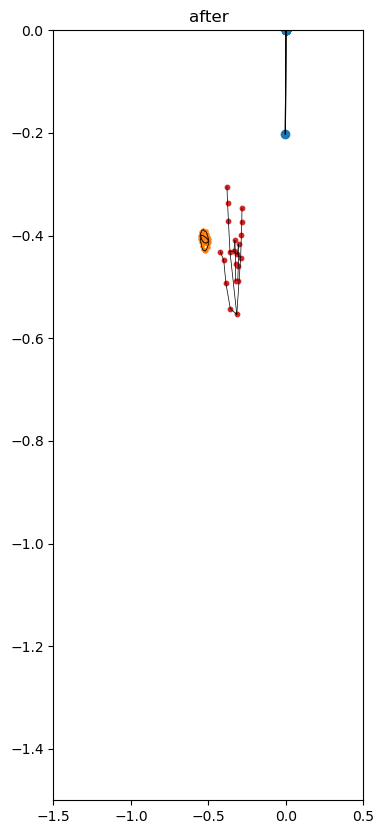

In [45]:
anim = visualize_target_samples([X],y)
HTML(anim.to_jshtml())